# **Import Required Libraries** 👇

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

/home/mado/Documents/SST_Text-Classification/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **Data Loading And Preprocessing** 📚


*   Load the SST dataset.
*   Map sentiment scores to classes as specified.
  





In [2]:
# Load the SST dataset
dataset = load_dataset('sst')

# Print keys in one example
print(dataset['train'][0].keys())

dict_keys(['sentence', 'label', 'tokens', 'tree'])


In [3]:
# Map sentiment scores to classes
def map_sentiment_to_class(score):
    if score <= 0.2:
        return 0  # very negative
    elif score <= 0.4:
        return 1  # negative
    elif score <= 0.6:
        return 2  # neutral
    elif score <= 0.8:
        return 3  # positive
    else:
        return 4  # very positive

# Apply the mapping to the dataset
dataset = dataset.map(lambda example: {'text': example['sentence'], 'label': map_sentiment_to_class(example['label'])})

# Split the dataset into training and testing sets
train_dataset = dataset['train']
test_dataset = dataset['test']

# Display the first few examples
print(train_dataset[0])
print(test_dataset[0])

Map: 100%|██████████| 2210/2210 [00:00<00:00, 13595.40 examples/s]

{'sentence': "The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .", 'label': 3.0, 'tokens': "The|Rock|is|destined|to|be|the|21st|Century|'s|new|``|Conan|''|and|that|he|'s|going|to|make|a|splash|even|greater|than|Arnold|Schwarzenegger|,|Jean-Claud|Van|Damme|or|Steven|Segal|.", 'tree': '70|70|68|67|63|62|61|60|58|58|57|56|56|64|65|55|54|53|52|51|49|47|47|46|46|45|40|40|41|39|38|38|43|37|37|69|44|39|42|41|42|43|44|45|50|48|48|49|50|51|52|53|54|55|66|57|59|59|60|61|62|63|64|65|66|67|68|69|71|71|0', 'text': "The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal ."}
{'sentence': 'Effective but too-tepid biopic', 'label': 2.0, 'tokens': 'Effective|but|too-tepid|biopic', 'tree': '6|6|5|5|7|7|0', 'text': 'Effective but too-tepid biopic'}


# **Naive Bayes Implementation** 🎰

- Implement the Naive Bayes algorithm using NumPy.
- Train the Naive Bayes classifier on the training data.
- Test the Naive Bayes classifier on the test data.

# ***Training Function "Learning"*** 🏫

In [4]:
def train_naive_bayes(train_data):

    # A] Calculate P(c) "Prior Probabilities":

    N_doc = len(train_data)  # Get Total number of documents in the training dataset
    classes, counts = np.unique([data['label'] for data in train_data], return_counts=True) # Calculate the number of documents for each class and their counts in np arrays
    logprior = np.log(counts / N_doc)  # Calculate the log of the prior probabilities

    # ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

    # B] Calculate P(w|c) "Cinditional Probabilities":

    vocabulary = set()  # Initialize an empty set to store the unique words in the vocabulary (no redundancy)
    bigdoc = {c: [] for c in classes}  # Initialize an empty dictionary to store the words for each class

    for data in train_data:
        c = data['label']  # Get the class label of the document
        bigdoc[c].extend(data['text'].split())  # Add the words from the document to the corresponding class
        vocabulary.update(data['text'].split())  # Update the vocabulary with the words from the document

    vocabulary = list(vocabulary)  # Convert the vocabulary set to a list
    V = len(vocabulary)  # Calculate the size of the vocabulary
    loglikelihood = {}  # Initialize an empty dictionary to store the log likelihood terms

    for c in classes:
        count_wc = np.array([bigdoc[c].count(w) for w in vocabulary]) # Calculate the count of each word in the vocabulary for the current class
        loglikelihood[c] = np.log((count_wc + 1) / (len(bigdoc[c]) + V)) # Calculate the logarithm of the likelihood probabilities (ASSUME using add-1 smoothing!)

    # ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

    return logprior, loglikelihood, vocabulary


# ***Visualize the distribution of Log probs of each CLASS*** 👀

In [6]:
def plot_log_probabilities(loglikelihood, vocabulary):
    plt.figure(figsize=(12, 6))
    for c, logprobs in loglikelihood.items():
        plt.hist(logprobs, bins=50, alpha=0.5, label=f'Class {c}')
    plt.xlabel('Log Probability')
    plt.ylabel('Frequency')
    plt.title('Distribution of Log Probabilities for Each Class')
    plt.legend()
    plt.show()



# ***Test Function "Predicting"*** 🤔

In [7]:
def test_naive_bayes(test_data, logprior, loglikelihood, vocabulary):
    predictions = []  # Initialize an empty list to store the predicted classes
    for data in test_data:
        max_sum = float('-inf')  # Initialize max_sum to negative infinity
        best_class = None  # Initialize best_class to None
        for c, logprior_c in enumerate(logprior):
            sum_c = logprior_c  # Start sum_c with the log prior for class c
            for word in data['text'].split():
                if word in vocabulary:  # Check if the word is in the vocabulary
                    word_index = vocabulary.index(word)
                    sum_c += loglikelihood[c][word_index]  # Add the log likelihood for the current word and class to the sum
            if sum_c > max_sum:
                max_sum = sum_c
                best_class = c
        predictions.append(best_class)  # Append the best class as the prediction

    return predictions

In [8]:
cnt=0
logprior, loglikelihood, vocabulary=train_naive_bayes(train_dataset)
predictions = test_naive_bayes(test_dataset, logprior, loglikelihood, vocabulary)
for i in range(len(predictions)):
    if predictions[i]==test_dataset[i]['label']:
        cnt+=1

# compute accuracy
accuracy = cnt/len(test_dataset)

print(f'Test Accuracy: {accuracy}')
print(f'Number of wrong predicted sentences:{len(test_dataset)-cnt}')

Test Accuracy: 0.39683257918552034
Number of wrong predicted sentences:1333


In [9]:
print(len(vocabulary))

18278


# ***Let's Try Our Model!*** 👀

> Indented block



In [ ]:
# Train the Naive Bayes classifier
logprior, loglikelihood, vocabulary = train_naive_bayes(train_dataset)

# Test the Naive Bayes classifier
predictions = test_naive_bayes(test_dataset, logprior, loglikelihood, vocabulary)

# Extract the original labels from the test dataset
true_labels = [data['label'] for data in test_dataset]

# Display the first few predictions and original labels
for i in range(5):
    print(f"Prediction: {predictions[i]}, Original Label: {true_labels[i]}")

Prediction: 2, Original Label: 2.0
Prediction: 3, Original Label: 3.0
Prediction: 3, Original Label: 4.0
Prediction: 3, Original Label: 2.0
Prediction: 4, Original Label: 4.0


# **Confusion Matrix & Evaluation Metrics** 😞

- Implement a function to generate the confusion matrix.
- Compute precision, recall, and F1 score per class and macro averaged.

In [ ]:
def confusion_matrix(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for true, pred in zip(y_true, y_pred):
        cm[int(true), int(pred)] += 1
    return cm

def plot_confusion_matrix(conf_matrix, num_classes):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # Set font scale
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
def precision_recall_f1(cm):
    precision = np.zeros(len(cm))
    recall = np.zeros(len(cm))
    f1 = np.zeros(len(cm))
    for i in range(len(cm)):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp
        precision[i] = tp / (tp + fp) if tp + fp > 0 else 0
        recall[i] = tp / (tp + fn) if tp + fn > 0 else 0
        f1[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i]) if precision[i] + recall[i] > 0 else 0
    return precision, recall, f1

In [ ]:
def plot_metrics_per_class(precision, recall, f1):
    labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']
    x = range(len(labels))

    plt.figure(figsize=(10, 6))
    bar_width = 0.25

    plt.bar(x, precision, bar_width, label='Precision', color='b', align='center')
    plt.bar([i + bar_width for i in x], recall, bar_width, label='Recall', color='g', align='center')
    plt.bar([i + 2*bar_width for i in x], f1, bar_width, label='F1 Score', color='r', align='center')

    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.title('Metrics per Class')
    plt.xticks([i + bar_width for i in x], labels)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ***Apply Implemented Metrics To Our Model*** 😟

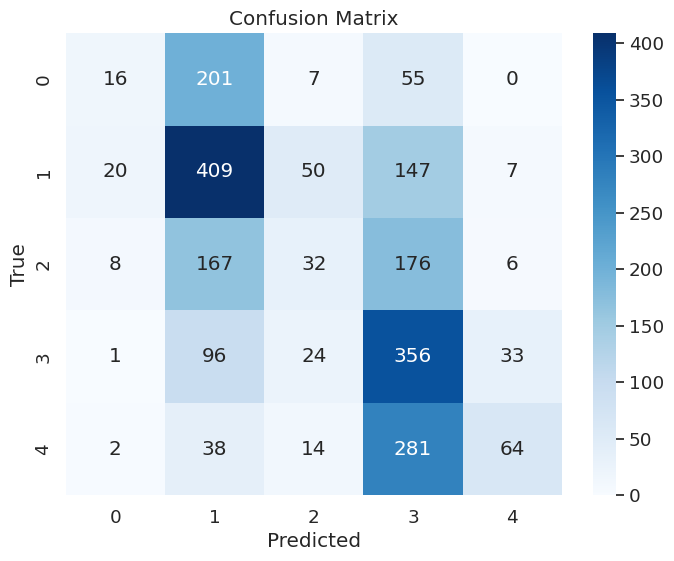

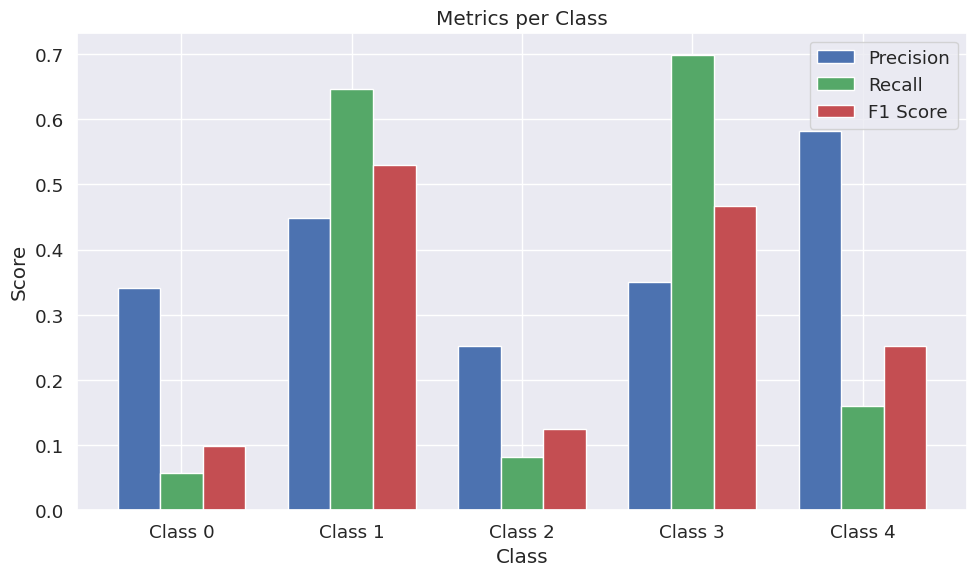

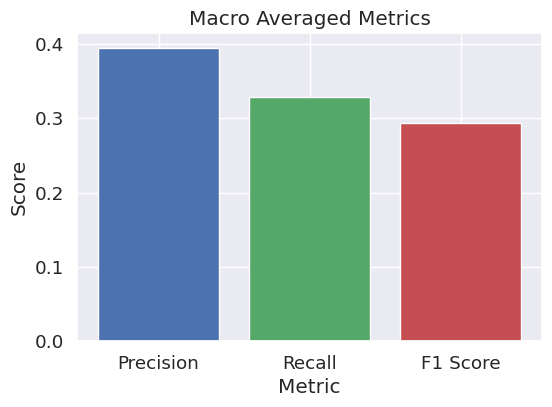


Precision per class: [0.34042553 0.44895719 0.2519685  0.35073892 0.58181818]
Recall per class: [0.05734767 0.64612954 0.08226221 0.69803922 0.160401  ]
F1 Score per class: [0.09815951 0.52979275 0.12403101 0.46688525 0.25147348]

Macro Averaged Precision: 0.3947816647654897
Macro Averaged Recall: 0.3288359282208981
Macro Averaged F1 Score: 0.2940683972753402


In [ ]:
# Generate and plot the confusion matrix
conf_matrix = confusion_matrix([data['label'] for data in test_dataset], predictions, 5)
plot_confusion_matrix(conf_matrix, 5)

# Compute precision, recall, and F1 score
precision, recall, f1 = precision_recall_f1(conf_matrix)

# Compute macro averaged precision, recall, and F1 score
macro_precision = np.mean(precision)
macro_recall = np.mean(recall)
macro_f1 = np.mean(f1)

# Plot precision, recall, and F1 score per class
plot_metrics_per_class(precision, recall, f1)

# Plot macro averaged precision, recall, and F1 score
plt.figure(figsize=(6, 4))
metrics = [macro_precision, macro_recall, macro_f1]
labels = ['Precision', 'Recall', 'F1 Score']
plt.bar(labels, metrics, color=['b', 'g', 'r'])
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Macro Averaged Metrics')
plt.show()

print("\nPrecision per class:", precision)
print("Recall per class:", recall)
print("F1 Score per class:", f1)
print("\nMacro Averaged Precision:", macro_precision)
print("Macro Averaged Recall:", macro_recall)
print("Macro Averaged F1 Score:", macro_f1)

# **Comparison with scikit-learn**

- Use scikit-learn to reproduce the results using a pipeline of CountVectorizer followed by MultinomialNB.

In [ ]:
# Define the scikit-learn pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB())
])

In [ ]:
# Train the model
pipeline.fit([data['text'] for data in train_dataset], [data['label'] for data in train_dataset])

Pipeline(steps=[('vect', CountVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Test the model
sklearn_predictions = pipeline.predict([data['text'] for data in test_dataset])

Confusion Matrix (scikit-learn):


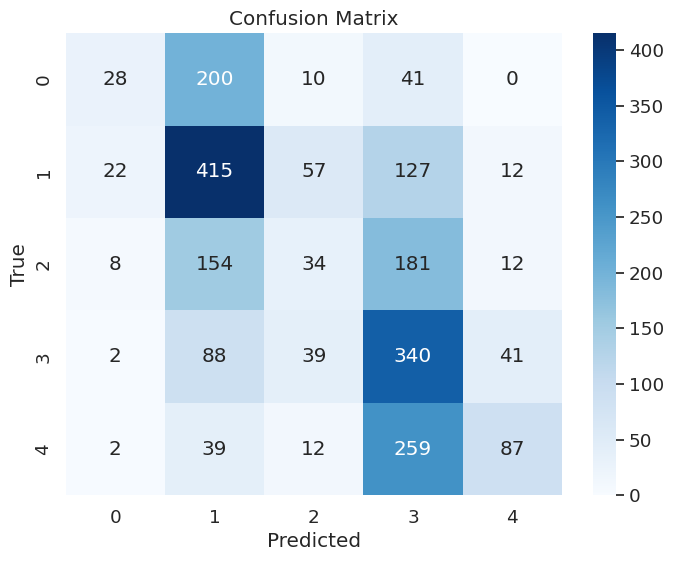

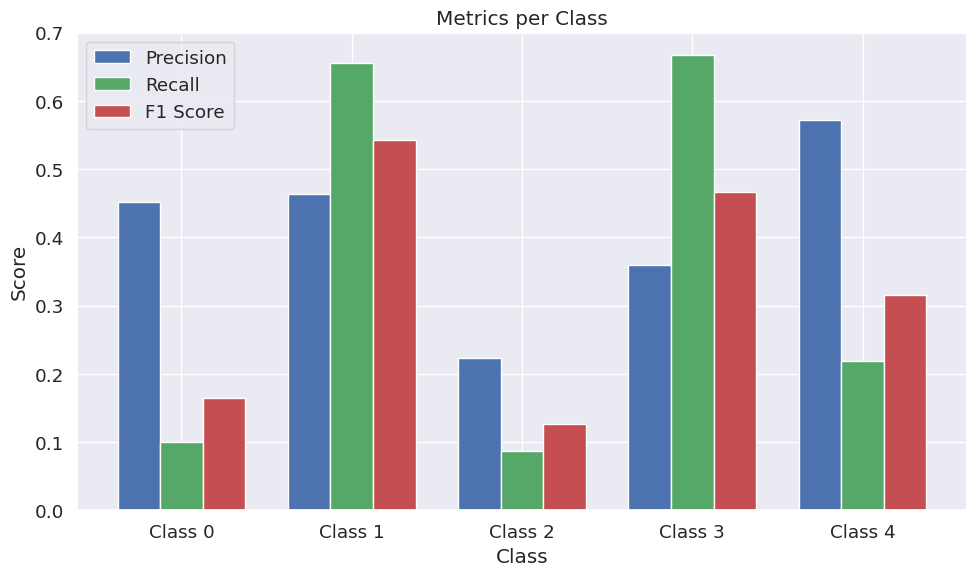

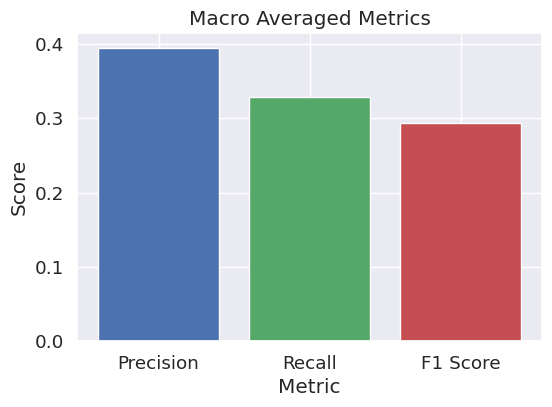


Precision per class (scikit-learn): [0.4516129  0.46316964 0.22368421 0.35864979 0.57236842]
Recall per class (scikit-learn): [0.10035842 0.65560821 0.0874036  0.66666667 0.21804511]
F1 Score per class (scikit-learn): [0.16422287 0.54283846 0.12569316 0.46639232 0.31578947]

Macro Averaged Precision (scikit-learn): 0.41389699333828645
Macro Averaged Recall (scikit-learn): 0.3456164032418666
Macro Averaged F1 Score (scikit-learn): 0.3229872566299008


In [ ]:
# Generate and plot the confusion matrix
conf_matrix_SK = confusion_matrix([data['label'] for data in test_dataset], sklearn_predictions, 5)
print("Confusion Matrix (scikit-learn):")
plot_confusion_matrix(conf_matrix_SK, 5)

# Compute precision, recall, and F1 score
precision_SK, recall_SK, f1_SK, _ = precision_recall_fscore_support([data['label'] for data in test_dataset], sklearn_predictions, average=None)
macro_precision_SK, macro_recall_SK, macro_f1_SK, _ = precision_recall_fscore_support([data['label'] for data in test_dataset], sklearn_predictions, average='macro')

# Plot precision, recall, and F1 score per class
plot_metrics_per_class(precision_SK, recall_SK, f1_SK)

# Plot macro averaged precision, recall, and F1 score
plt.figure(figsize=(6, 4))
metrics = [macro_precision, macro_recall, macro_f1]
labels = ['Precision', 'Recall', 'F1 Score']
plt.bar(labels, metrics, color=['b', 'g', 'r'])
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Macro Averaged Metrics')
plt.show()


print("\nPrecision per class (scikit-learn):", precision_SK)
print("Recall per class (scikit-learn):", recall_SK)
print("F1 Score per class (scikit-learn):", f1_SK)

print("\nMacro Averaged Precision (scikit-learn):", macro_precision_SK)
print("Macro Averaged Recall (scikit-learn):", macro_recall_SK)
print("Macro Averaged F1 Score (scikit-learn):", macro_f1_SK)

# ***Comparasion***

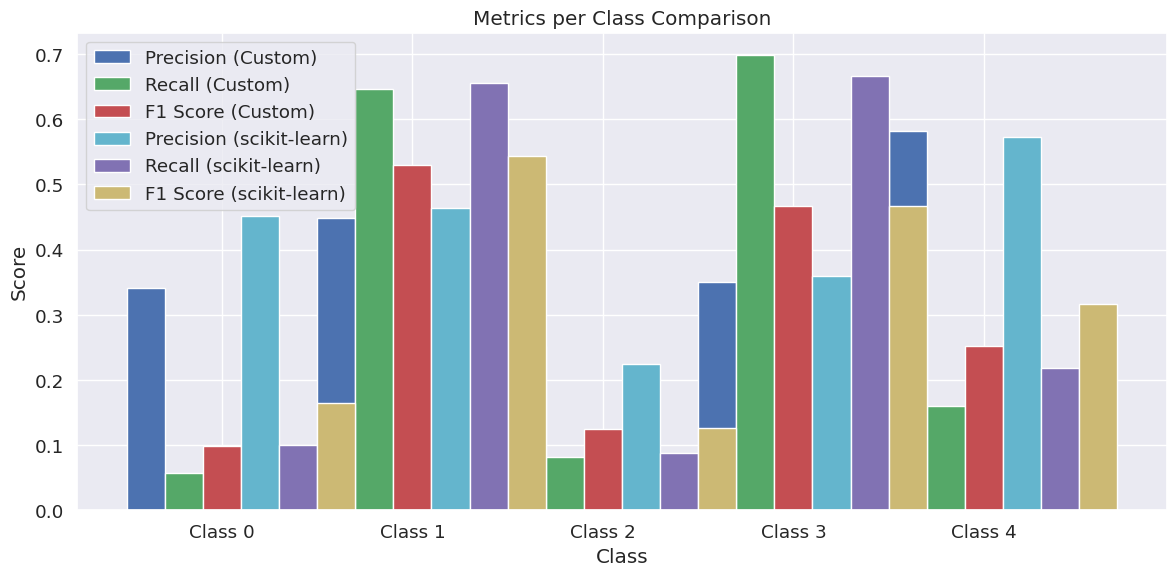

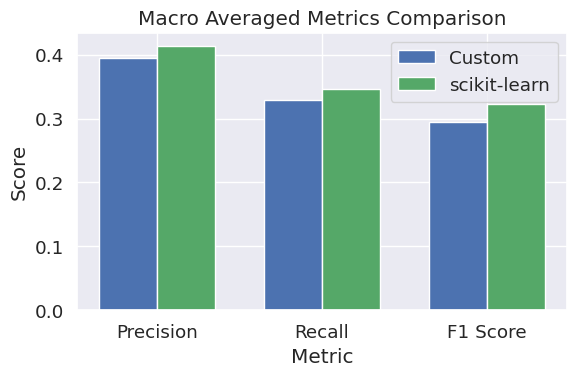

In [ ]:
# Plot precision, recall, and F1 score per class for both implementations
plt.figure(figsize=(12, 6))
bar_width = 0.2
index = np.arange(5)

plt.bar(index, precision, bar_width, label='Precision (Custom)', color='b', align='center')
plt.bar(index + bar_width, recall, bar_width, label='Recall (Custom)', color='g', align='center')
plt.bar(index + 2*bar_width, f1, bar_width, label='F1 Score (Custom)', color='r', align='center')

plt.bar(index + 3*bar_width, precision_SK, bar_width, label='Precision (scikit-learn)', color='c', align='center')
plt.bar(index + 4*bar_width, recall_SK, bar_width, label='Recall (scikit-learn)', color='m', align='center')
plt.bar(index + 5*bar_width, f1_SK, bar_width, label='F1 Score (scikit-learn)', color='y', align='center')

plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Metrics per Class Comparison')
plt.xticks(index + 2*bar_width, ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.legend()
plt.tight_layout()
plt.show()

# Plot macro averaged precision, recall, and F1 score for both implementations
plt.figure(figsize=(6, 4))
metrics_custom = [macro_precision, macro_recall, macro_f1]
metrics_sklearn = [macro_precision_SK, macro_recall_SK, macro_f1_SK]
labels = ['Precision', 'Recall', 'F1 Score']
bar_width = 0.35
index = np.arange(3)

plt.bar(index, metrics_custom, bar_width, label='Custom', color='b', align='center')
plt.bar(index + bar_width, metrics_sklearn, bar_width, label='scikit-learn', color='g', align='center')

plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Macro Averaged Metrics Comparison')
plt.xticks(index + bar_width/2, labels)
plt.legend()
plt.tight_layout()
plt.show()
